In [1]:
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning)
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

import pandas as pd
import numpy as np
# import re
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.decomposition import NMF, LatentDirichletAllocation


from sklearn.cluster import KMeans # try other clusering algorithms

import util as u
import text_processing as tp
%load_ext autoreload
%autoreload 2

import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

from sklearn.metrics.pairwise import cosine_similarity

from sklearn.cluster import KMeans

In [ ]:
# from nltk.cluster.kmeans import KMeansClusterer
# from nltk.cluster.util import cosine_distance

### Load data

In [2]:
df = u.open_pkl('Data/all_lyrics_df_181109.pkl')

In [3]:
country_idx_start = np.min(list(df[df['Genre'] == 'country'].index))

In [4]:
X = df[['Lyrics']].values
X = X.tolist()
X = [x[0] for x in X]

## CountVectorizer

In [5]:
cv_vect = CountVectorizer(preprocessor=tp.my_preprocessor, stop_words = tp.stop_words(), 
#                              tokenizer=tp.porter_tokenizer,
                             ngram_range=(1,2), encoding = 'ISO-8859-1', 
                             strip_accents='ascii', min_df = 2, max_df=0.5)

transX = cv_vect.fit_transform(X) # dtm, or document-term matrix

features = cv_vect.get_feature_names()
len(features)

44962

In [6]:
cv_vocab = cv_vect.vocabulary_

tf_df = pd.DataFrame(transX.toarray(), columns=cv_vect.get_feature_names())

word_frequs = np.sum(tf_df)
# word_frequs.sort_values(ascending=False)[:20]

In [14]:
# un-false-ify to save 
if 1 == 0:
    u.pkl_this('Data/dtm_tf_df.pkl', tf_df)
    u.pkl_this('Data/word_frequ.pkl', word_frequs)
    u.pkl_this('Data/cv_vocab.pkl', cv_vocab)
    u.pkl_this('Data/dtm_tf.pkl', transX)

## LDA

In [7]:
# previously determined 9 to be optimal number of topics by visual inspection of topic words & separation on pyLDA viz
n = 9
lda = LatentDirichletAllocation(n_components=n, max_iter=10,
                                learning_method='online',
                                learning_offset=10.,
                                random_state=12,
                               doc_topic_prior=0.05)

lda.fit(transX)

# for topic in range(n):
#     print(f"TOPIC {topic}")
#     for j in np.argsort(-lda.components_,1)[topic,:10]:
#         print(features[j])
#     print()

LatentDirichletAllocation(batch_size=128, doc_topic_prior=0.05,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='online', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=9, n_jobs=None, n_topics=None, perp_tol=0.1,
             random_state=12, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)

In [8]:
lda_topics = []
for topic in range(n):
    word_list = []
    for j in np.argsort(-lda.components_,1)[topic,:30]:
        word_list.append(features[j])
    lda_topics.append(word_list)

lda_X = lda.transform(transX)

In [14]:
lda_viz = pyLDAvis.sklearn.prepare(lda, transX, cv_vect)
# pyLDAvis.save_html(lda_viz, f'Data/pyLDAvis_AllLyrics_LDA{n}.html')  # see html file to view visualization

In [10]:
u.pkl_this('Data/lda_transformed_mtx.pkl', lda_X)

In [9]:
lda_topics

[['gonna',
  'lie',
  'dance',
  'boom',
  'bubble',
  'dang',
  'dance dance',
  'around',
  'lie lie',
  'ring',
  'butt',
  'boom boom',
  'cowboy',
  'amazing',
  'open',
  'beat',
  'wicked',
  'amazing amazing',
  'ever gonna',
  'night',
  'around around',
  'ew',
  'luv',
  'another round',
  'gonna wish',
  'name',
  'world',
  'kick',
  'dang dang',
  'wide'],
 ['baby',
  'girl',
  'love',
  'tonight',
  'baby baby',
  'hangover',
  'want',
  'hangover hangover',
  'girl girl',
  'still',
  'stay',
  'love still',
  'mmm',
  'little',
  'lips',
  'still love',
  'ba',
  'time',
  'tired',
  'jingle',
  'whistle',
  'around',
  'girl gotta',
  'love baby',
  'play',
  'come',
  'seat',
  'tonight tonight',
  'turning',
  'give'],
 ['little',
  'little bit',
  'bit',
  'burn',
  'moonlight',
  'drink',
  'slow',
  'turn',
  'double',
  'hmm',
  'party',
  'sweet',
  'turn turn',
  'getting',
  'hmm hmm',
  'drink little',
  'dee',
  'high',
  'parking lot',
  'dee double',
  'p

## Similarity

Songs are arranged in order of genre in dataframe: rap, then country.
So to quickly determine if a song is more similar to rap or country songs, 
we can compute the median index of top-20 most-similar songs and see if it falls
before or after the "switch" of index from rap to country

#### Cosine Similarity

In [15]:
cos_sim_mtx = cosine_similarity(lda_X, lda_X)
most_sim_idx_range = [np.median(np.argsort(-x)[1:21]) for x in cos_sim_mtx]

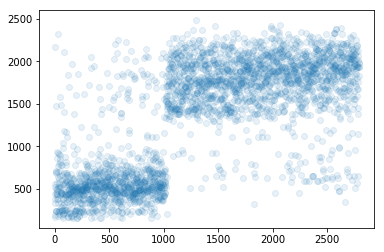

In [17]:
plt.plot(most_sim_idx_range, 'o', alpha=0.1)

In [20]:
df['Most Sim Idx 1'] = pd.Series(most_sim_idx_range)

#### Hellinger distance
A measure of distance between two probability vectors. Note that since this is a distance, larger numbers mean less similar; smaller numbers mean more similar.

code from: https://blakeboswell.github.io/2016/07/15/gensim-hellinger.html

In [30]:
import numpy as np
from scipy.spatial.distance import pdist, squareform

def hellinger(X):
    return squareform(pdist(np.sqrt(X)))/np.sqrt(2)

In [52]:
hd_mtx = hellinger(lda_X)

most_sim_idx_range = [np.median(np.argsort(x)[1:21]) for x in hd_mtx]

df['Most Sim Idx HD'] = pd.Series(most_sim_idx_range)

In [53]:
rap_df, cnty_df = u.rap_cnty_dfs(df)

#### Compare the two:

In [39]:
# compute percent of songs that are "mis-labeled"
rap_pct = (len(rap_df[rap_df['Most Sim Idx HD'] > country_idx_start]) / len(rap_df)) * 100 
cnty_pct = (len(cnty_df[cnty_df['Most Sim Idx HD'] < country_idx_start]) / len(cnty_df)) * 100

print("Using Hellinger Distance:")
print(f'Rap songs more similar to Country songs: {rap_pct: .2f}%') 
print(f'Country songs more similar to Rap songs: {cnty_pct: .2f}%') 

Using Hellinger Distance:
Rap songs more similar to Country songs:  8.64%
Country songs more similar to Rap songs:  4.11%


In [40]:
# compute percent of songs that are "mis-labeled"
rap_pct = (len(rap_df[rap_df['Most Sim Idx 1'] > country_idx_start]) / len(rap_df)) * 100 
cnty_pct = (len(cnty_df[cnty_df['Most Sim Idx 1'] < country_idx_start]) / len(cnty_df)) * 100
print("Using Cosine Similarity:")
print(f'Rap songs more similar to Country songs: {rap_pct: .2f}%') 
print(f'Country songs more similar to Rap songs: {cnty_pct: .2f}%') 

Using Cosine Similarity:
Rap songs more similar to Country songs:  9.42%
Country songs more similar to Rap songs:  4.95%


*Hellinger Distance performs better*

In [41]:
df.drop(columns=['Most Sim Idx 1'], inplace=True)
df.rename(columns={'Most Sim Idx HD': 'Meidan Most Sim Idx'}, inplace=True)
most_sim = [np.argsort(x)[1:21] for x in hd_mtx]
df['Top 20 Most Sim'] = pd.Series(most_sim)

In [55]:
df.head()

,ID,Song,Artist,Album,Genre,Lyrics,Meidan Most Sim Idx,Top 20 Most Sim
0,Lucid Dreams - Juice WRLD,Lucid Dreams,Juice WRLD,JuiceWRLD 9 9 9,rap,"\n\n[Intro]\nEnviyon on the mix\nNo, no, no, n...",2085.5,"[1863, 2592, 2429, 1130, 1557, 2703, 1616, 112..."
1,Better Now - Post Malone,Better Now,Post Malone,​beerbongs & bentleys,rap,\n\n[Chorus]\nYou prolly think that you are be...,759.0,"[558, 483, 659, 993, 857, 758, 769, 449, 862, ..."
2,ZEZE - Kodak Black,ZEZE,Kodak Black,KB2,rap,\n\n[Intro]\nD.A. got that dope!\n\n[Chorus: T...,196.0,"[151, 124, 330, 165, 884, 130, 601, 362, 203, ..."
3,Drip Too Hard - Lil Baby,Drip Too Hard,Lil Baby,Drip Harder,rap,"\n\n[Intro]\nRun that back, Turbo\n\n[Verse 1:...",446.0,"[413, 728, 935, 620, 617, 325, 535, 339, 732, ..."
4,Mo Bamba - Sheck Wes,Mo Bamba,Sheck Wes,MUDBOY,rap,\n\n[Intro]\n16yrold\nBitch!\nDaytrip took it ...,424.0,"[198, 303, 23, 694, 716, 665, 671, 162, 425, 2..."


In [144]:
# u.pkl_this('Data/all_lyrics_with_sim_df.pkl', df)

## K-means Clustering

In [153]:
n_range = np.arange(2,21)

# lda_trans

inerts = []
for n in range(2,21):
    km = KMeans(n_clusters=n)
    km.fit(lda_X)
    inerts.append(km.inertia_)

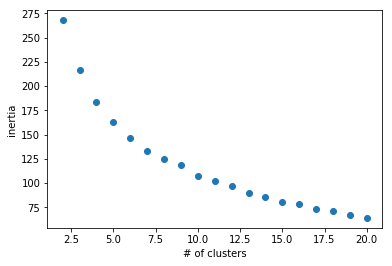

In [154]:
plt.scatter(n_range, inerts)
plt.xlabel('# of clusters')
plt.ylabel('inertia');

Despite all this, use 2 clusters, since this is the number of genres we have

#### Euclidean distance (sklearn's default)

In [48]:
n_clust = 2
km_final = KMeans(n_clusters=n_clust)
km_final.fit(lda_X)
cluster_centers = km_final.cluster_centers_
cluster_labels = km_final.labels_

In [ ]:
y = n_clust

In [56]:
df['Cluster Labels 2'] = pd.Series(cluster_labels)

In [57]:
rap_df, cnty_df = u.rap_cnty_dfs(df)

[0.20804710500490678, 0.7919528949950932] [0.9746621621621622, 0.02533783783783784]


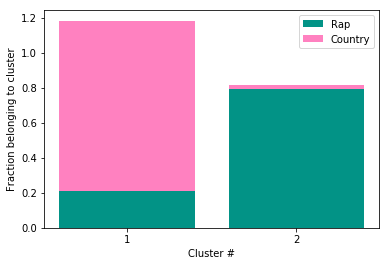

In [67]:
rap_label_pcts = [np.sum(rap_df['Cluster Labels 2'] == i)/len(rap_df) for i in range(n_clust)] 
cnty_label_pcts = [np.sum(cnty_df['Cluster Labels 2'] == i)/len(cnty_df) for i in range(n_clust)] 
print (rap_label_pcts, cnty_label_pcts)

plt.bar(range(y), rap_label_pcts, color='xkcd:teal', label='Rap')
plt.bar(range(y), cnty_label_pcts, bottom=rap_label_pcts, color='xkcd:pink', label='Country')
plt.xlabel('Cluster #')
plt.ylabel('Fraction belonging to cluster')
plt.xticks(range(y), labels=[f'{i+1}' for i in range(y)])
plt.legend();

#### Cosine Distance (nltk)
https://stackoverflow.com/questions/5529625/is-it-possible-to-specify-your-own-distance-function-using-scikit-learn-k-means

In [ ]:
from nltk.cluster.kmeans import KMeansClusterer
from nltk.cluster.util import cosine_distance

kmc = KMeansClusterer(n_clust, distance=cosine_distance, repeats=25)
assigned_clusters = kmc.cluster(lda_X, assign_clusters=True)

In [62]:
df['Cluster Labels 2 Cosine'] = pd.Series(assigned_clusters)

In [63]:
rap_df, cnty_df = u.rap_cnty_dfs(df)

[0.745829244357213, 0.25417075564278707] [0.01126126126126126, 0.9887387387387387]


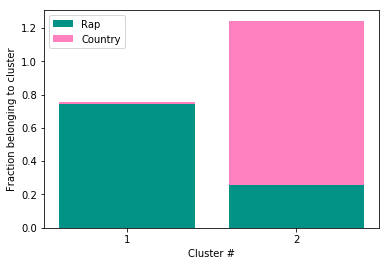

In [74]:
rap_label_pcts = [np.sum(rap_df['Cluster Labels 2 Cosine'] == i)/len(rap_df) for i in range(n_clust)] 
cnty_label_pcts = [np.sum(cnty_df['Cluster Labels 2 Cosine'] == i)/len(cnty_df) for i in range(n_clust)] 

print (rap_label_pcts, cnty_label_pcts)

y = n_clust
plt.bar(range(y), rap_label_pcts, color='xkcd:teal', label='Rap')
plt.bar(range(y), cnty_label_pcts, bottom=rap_label_pcts, color='xkcd:pink', label='Country')
plt.xlabel('Cluster #')
plt.ylabel('Fraction belonging to cluster')
plt.xticks(range(y), labels=[f'{i+1}' for i in range(y)])
plt.legend();

#### Hellinger Distance

In [70]:
# write HD function differently so it can be used in clustering function

from scipy.linalg import norm
from scipy.spatial.distance import euclidean

_SQRT2 = np.sqrt(2)     # sqrt(2) with default precision np.float64

def hellinger2(p, q):
    return norm(np.sqrt(p) - np.sqrt(q)) / _SQRT2

In [71]:
kmc_hd = KMeansClusterer(n_clust, distance=hellinger2, repeats=25)
assigned_clusters_hd = kmc_hd.cluster(lda_X, assign_clusters=True)

df['Cluster Labels 2 HD'] = pd.Series(assigned_clusters_hd)

In [72]:
rap_df, cnty_df = u.rap_cnty_dfs(df)

[0.8096172718351324, 0.1903827281648675] [0.018581081081081082, 0.981418918918919]


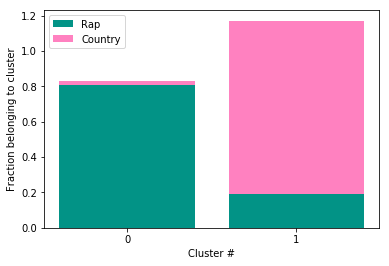

In [75]:
rap_label_pcts = [np.sum(rap_df['Cluster Labels 2 HD'] == i)/len(rap_df) for i in range(n_clust)] 
cnty_label_pcts = [np.sum(cnty_df['Cluster Labels 2 HD'] == i)/len(cnty_df) for i in range(n_clust)] 
print (rap_label_pcts, cnty_label_pcts)

plt.bar(range(n_clust), rap_label_pcts, color='xkcd:teal', label='Rap')
plt.bar(range(n_clust), cnty_label_pcts, bottom=rap_label_pcts, color='xkcd:pink', label='Country')
plt.xlabel('Cluster #')
plt.ylabel('Fraction belonging to cluster')
plt.xticks(range(n_clust), labels=[f'{i}' for i in range(n_clust)])
plt.legend();

Hellinger Distance is "best"